In [8]:
from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

LBP_METHOD               METHOD INTERPOLATION_ALGORITHM  BALANCE  \
Parameters        riu  get_pyramid_dataset                 lanczos    False   

            N_SCALES  GRAY_INTENSITY  X2SCALE  
Parameters         5            True     True

### Resultado CV

F1-score 0.685426

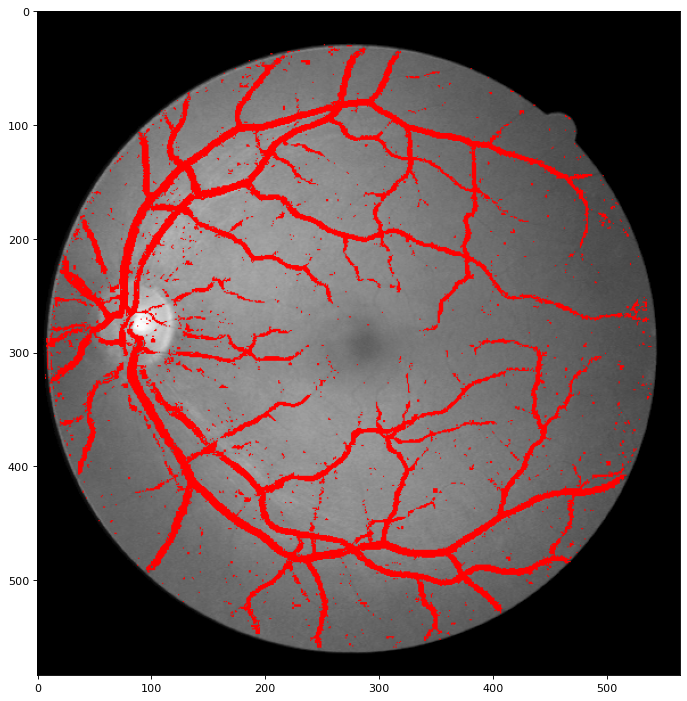

Accuracy score: 0.9292555186111174

F1 score: 0.7211952246541113

Confusion matrix:

     t/p      0     1 
        0 1141617 45928 
        1 50476 124686 
Sensivity: 0.7118324750802114
Specificity: 0.9613252550429668


(0.929, 0.721, 1141617, 45928, 50476, 124686)

In [9]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=['riu', 'var'], plot_once=True, channels=(1, 2), recurrence=False)

In [10]:
import pickle
from os import listdir

PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
MASK_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/mask'
LABELS_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

In [11]:
with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16506693338675942_200_iterations/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)
display(conv_features)

0   1   2    3    4   5
0        40   0   0   30  106  33
1        46   0   0   22   95  26
2        55   0   0    9   81  18
3        60   0   0    1   79  15
4        67   0   0    9   85  14
...      ..  ..  ..  ...  ...  ..
3178294  15  48  26  124  100  38
3178295  19  52  19  123   95  43
3178296  16  50  24  129   97  42
3178297  13  38  11  129   97  41
3178298  12  39   3  118   96  43

[3178299 rows x 6 columns]

In [12]:
import pandas as pd
import numpy as np

preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [13]:
from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test_features(features, verbose=False):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(
            df_train_temp, y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}

In [14]:
from main import get_channel_features, get_labels
import pandas as pd

df_train, df_test = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
conv_features.index = df_train.index
y_train, y_test = get_labels('../')

In [15]:
display(df_train)

df_train = pd.concat([df_train, conv_features], axis=1)

features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}

green_Original green_riu_1:1 green_riu_1:2 green_riu_1:4 green_riu_1:8  \
0                 0.0          35.0           8.0           8.0           8.0   
1                 0.0          27.0           8.0           8.0           8.0   
2                 0.0           8.0           8.0           8.0           8.0   
3                 0.0           4.0           8.0           8.0           8.0   
4                 0.0           8.0           8.0           8.0           8.0   
...               ...           ...           ...           ...           ...   
226537            0.0          16.0           4.0          27.0           8.0   
226538            0.0           8.0           4.0          27.0           8.0   
226539            0.0           8.0           8.0          16.0           8.0   
226540            0.0          16.0           8.0          16.0           8.0   
226541            0.0          16.0           8.0          16.0           8.0   

       green_riu_2:1_1 green_riu_2:1_2 green_riu_2:1_3 green_riu_2:1_4  \
0                 35.0            35.0             8.0             8.0   
1                 35.0            27.0             8.0             8.0   
2                 35.0            27.0            16.0             8.0   
3                  8.0             8.0             8.0             8.0   
4                  8.0             8.0             4.0             8.0   
...                ...             ...             ...             ...   
226537             8.0             8.0             8.0             8.0   
226538            16.0             8.0            35.0            35.0   
226539             8.0             8.0             8.0            16.0   
226540             8.0             8.0            16.0             8.0   
226541             8.0             8.0            34.0            35.0   

       blue_Original  ... green_var_2:1_3 green_var_2:1_4 blue_var_1:1  \
0                1.0  ...            55.0            69.0    27.176735   
1                1.0  ...            86.0           102.0    46.207535   
2                0.0  ...           138.0           154.0    70.187899   
3                0.0  ...           166.0           180.0    72.674270   
4                0.0  ...           196.0           214.0    62.853232   
...              ...  ...             ...             ...          ...   
226537           0.0  ...            84.0            75.0    19.041829   
226538           0.0  ...            69.0            66.0    18.681217   
226539           0.0  ...            61.0            51.0    13.971574   
226540           0.0  ...            41.0            28.0     9.588321   
226541           0.0  ...            15.0             7.0     6.568814   

       blue_var_1:2 blue_var_1:4 blue_var_1:8 blue_var_2:1_1 blue_var_2:1_2  \
0       1637.007165  1306.551069  1157.878241           10.0           13.0   
1       1637.007165  1306.551069  1157.878241           13.0           14.0   
2       1788.711292  1320.562749  1157.878241           11.0            9.0   
3       1788.711292  1320.562749  1157.878241            6.0            3.0   
4       1848.534023  1320.562749  1157.878241            2.0            2.0   
...             ...          ...          ...            ...            ...   
226537   295.481488   507.872500   985.396140            0.0            1.0   
226538   295.481488   507.872500   985.396140            1.0            2.0   
226539   228.299942   469.304608   985.396140            0.0            0.0   
226540   228.299942   469.304608   985.396140            0.0            0.0   
226541   143.415765   469.304608   985.396140            1.0            1.0   

       blue_var_2:1_3 blue_var_2:1_4  
0                 3.0            1.0  
1                 3.0            9.0  
2                 7.0            6.0  
3                11.0           27.0  
4                37.0           34.0  
...               ...            ...  
226537            0.0            0

In [16]:
test_features(features, verbose=True)

Accuracy score: 0.9384773864848645

F1 score: 0.72077628003623

Confusion matrix:

     t/p      0     1 
        0 585434 19875 
        1 22051 54113 
Sensivity: 0.71048001680584
Specificity: 0.9671655303324418
-------------------------------------
Accuracy score: 0.9248478343967773

F1 score: 0.680831933665091

Confusion matrix:

     t/p      0     1 
        0 574543  8262 
        1 42855 54520 
Sensivity: 0.5598973042362002
Specificity: 0.9858237317799264
-------------------------------------
Accuracy score: 0.9393460734810143

F1 score: 0.7531928594426358

Confusion matrix:

     t/p      0     1 
        0 577906 15538 
        1 25856 63162 
Sensivity: 0.7095418904041879
Specificity: 0.9738172430760106
-------------------------------------
Accuracy score: 0.9415123311526333

F1 score: 0.702301277156418

Confusion matrix:

     t/p      0     1 
        0 593232 13942 
        1 25824 46906 
Sensivity: 0.6449333150006875
Specificity: 0.9770378837038477
------------------------

{'acc': 0.930273724310595, 'f1': 0.7025475527128029}

0   1  2   3   4   5
0        9   2  0  33  85  33
1       10   2  0  32  79  31
2       11   1  0  34  81  37
3        9   1  0  37  90  36
4        8   4  0  33  86  43
...     ..  .. ..  ..  ..  ..
226969  13  23  0  62  60  33
226970  14  25  0  60  56  35
226971  12  25  1  62  57  33
226972  11  20  0  66  59  30
226973  10  19  5  47  56  33

[1362707 rows x 6 columns]

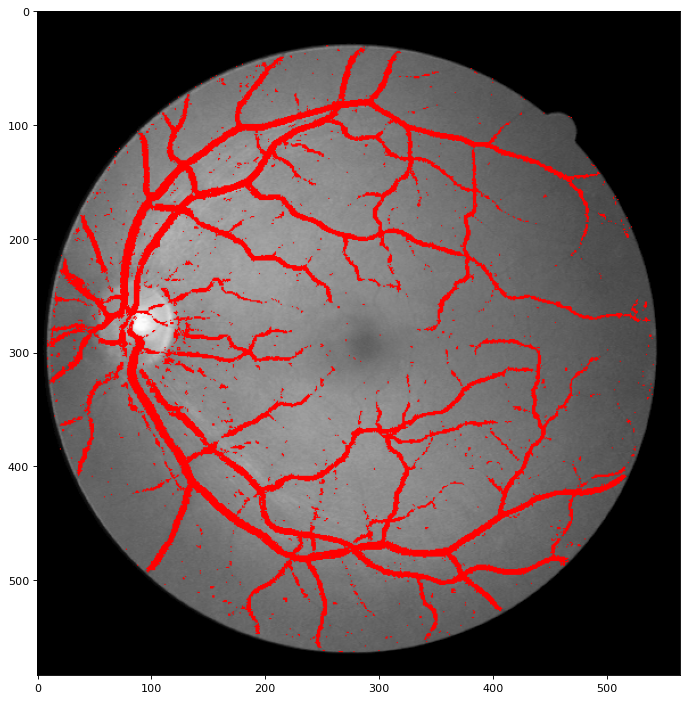

Accuracy score: 0.9352281891852027

F1 score: 0.7441720263059501

Confusion matrix:

     t/p      0     1 
        0 1146066 41479 
        1 46786 128376 
Sensivity: 0.7328986880716137
Specificity: 0.9650716393905073


(0.935, 0.744, 1146066, 41479, 46786, 128376)

In [17]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index
display(conv_features_test)

extra_features = {'train': conv_features, 'test': conv_features_test}
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=False)

### Clasificador utilizando únicamente la intensidad de gris en el canal verde

In [18]:
green_channel_train = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES, MASKS)] for item in sublist]
)
green_channel_train.index = y_train.index
green_channel_test = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES_test, MASKS_test)] for item in sublist]
)
green_channel_test.index = y_test.index

In [19]:
display(green_channel_train)

0
0        4
1        3
2        3
3       10
4        9
...     ..
226537   6
226538   3
226539   9
226540   4
226541   0

[3178299 rows x 1 columns]

In [20]:
features = {
    'x_train': green_channel_train, 'x_test': green_channel_test,
    'y_train': y_train, 'y_test': y_test
}

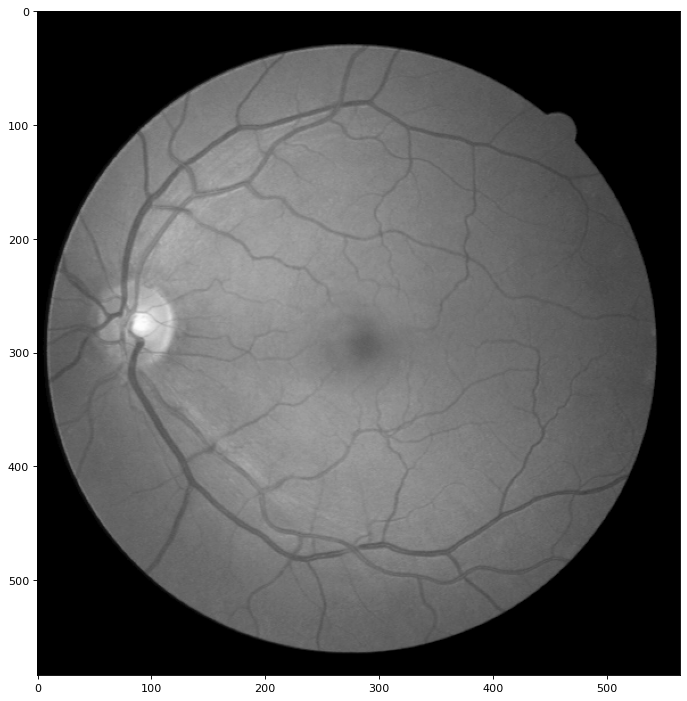

Accuracy score: 0.8714602625509372

F1 score: 0.0

Confusion matrix:

     t/p      0     1 
        0 1187545     0 
        1 175162     0 
Sensivity: 0.0
Specificity: 1.0


(0.871, 0.0, 1187545, 0, 175162, 0)

In [21]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

### Resultados convolución

Green channel


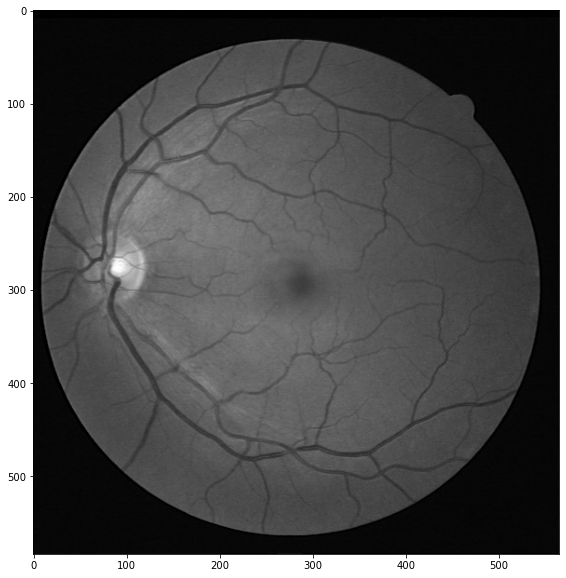


 Convolved images


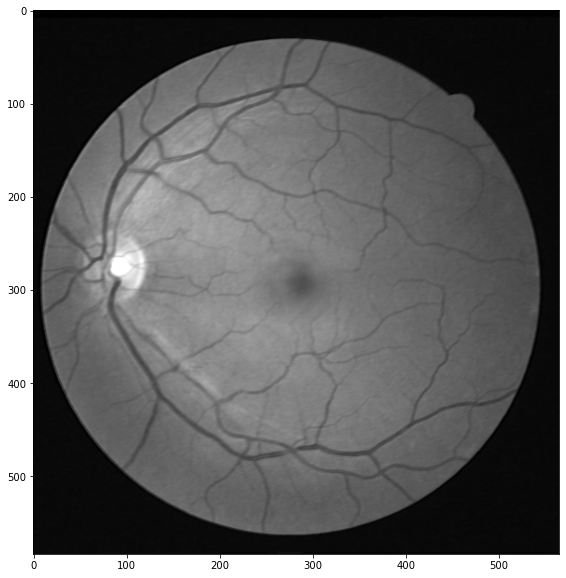

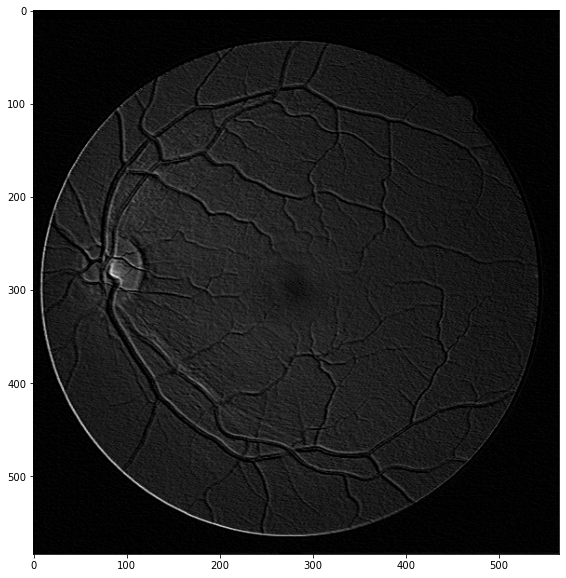

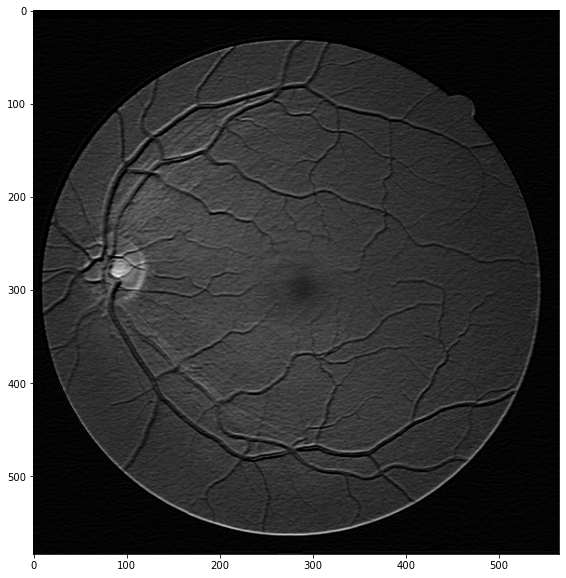

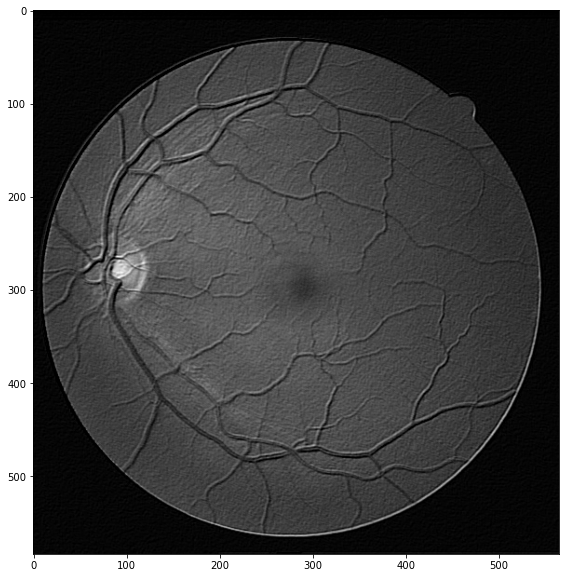

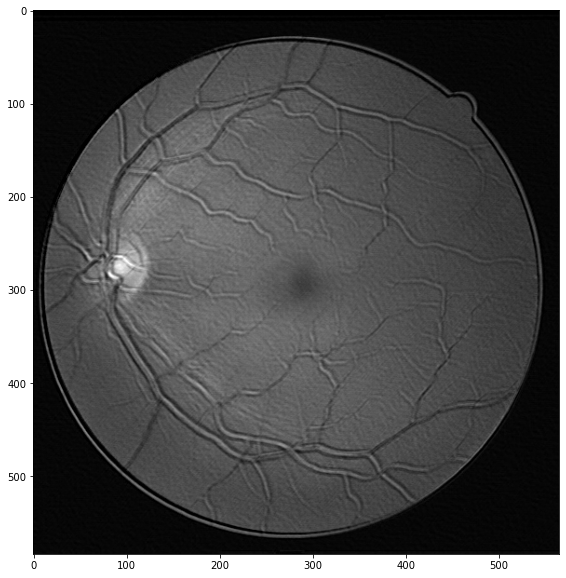

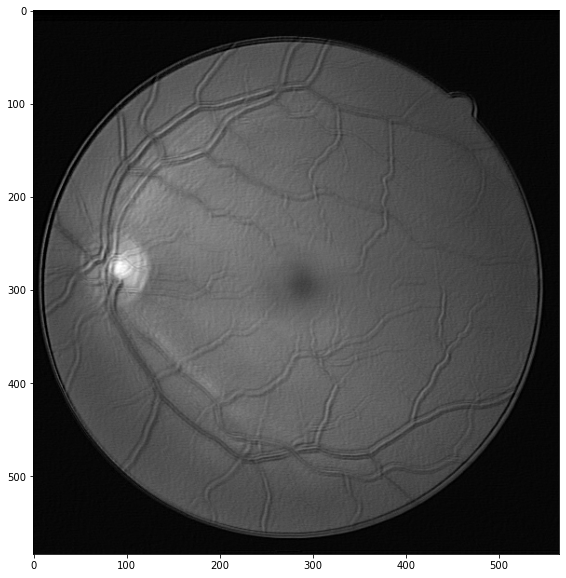

In [23]:
import numpy as np
import pickle


kernel_list = [population[np.argmax(fitness), k:k+9] for k in range(0, len(individual), 9)]

kernel_list = []
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    kernel_list += [
        individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks))
        for i in range(n_kernels // len(k_size))
    ]
    count += k_len * (n_kernels // len(k_size))


PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
path = PATH + '/35_training.tif'

from os import listdir
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from preprocess.preprocess import Preprocess

img = np.asarray(Image.open(path).convert('RGB'))[:, :, 1]
img_convolved = [cv2.filter2D(img, -1, k) for k in kernel_list]
import matplotlib.pyplot as plt
from PIL import Image
from convolution.fitness import IMAGES

im_list = [Image.fromarray(np.uint8(im)) for im in img_convolved]

print('Green channel')
plt.figure(figsize=(18, 10))
plt.imshow(img, cmap='gray')
plt.show()

print('\n Convolved images')
for im in im_list:
    plt.figure(figsize=(18, 10))
    plt.imshow(im, cmap='gray')
    plt.show()

In [28]:
features = {'x_train': extra_features['train'], 'x_test': extra_features['test'], 'y_train': y_train, 'y_test': y_test}

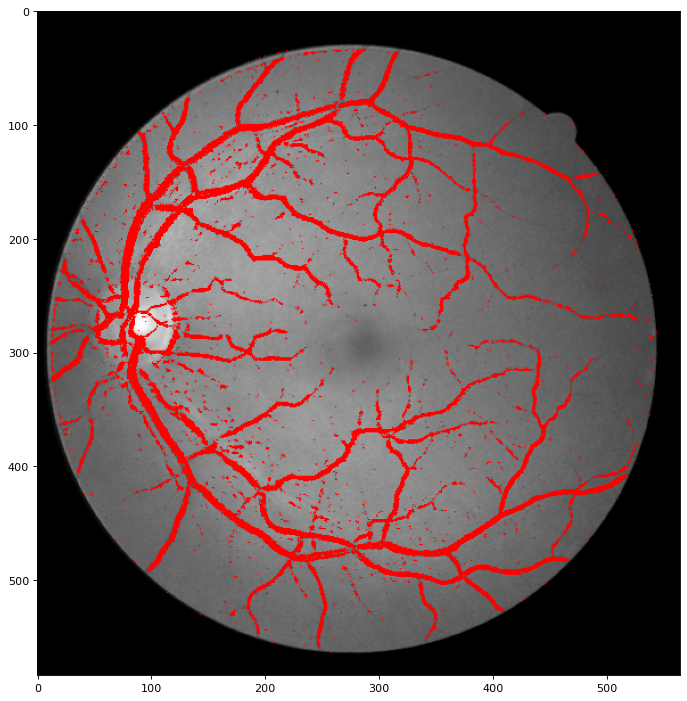

Accuracy score: 0.9305345903411372

F1 score: 0.7016944559116879

Confusion matrix:

     t/p      0     1 
        0 1156712 30833 
        1 63828 111334 
Sensivity: 0.6356058962560373
Specificity: 0.9740363523066494


(0.931, 0.702, 1156712, 30833, 63828, 111334)

In [29]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

## Combinación de resultados

In [30]:
green_channel_train.columns = ['green']
green_channel_test.columns = ['green']
features = {
    'x_train': pd.concat([extra_features['train'], green_channel_train], axis=1),
    'x_test': pd.concat([extra_features['test'], green_channel_test], axis=1),
    'y_train': y_train,
    'y_test': y_test
}

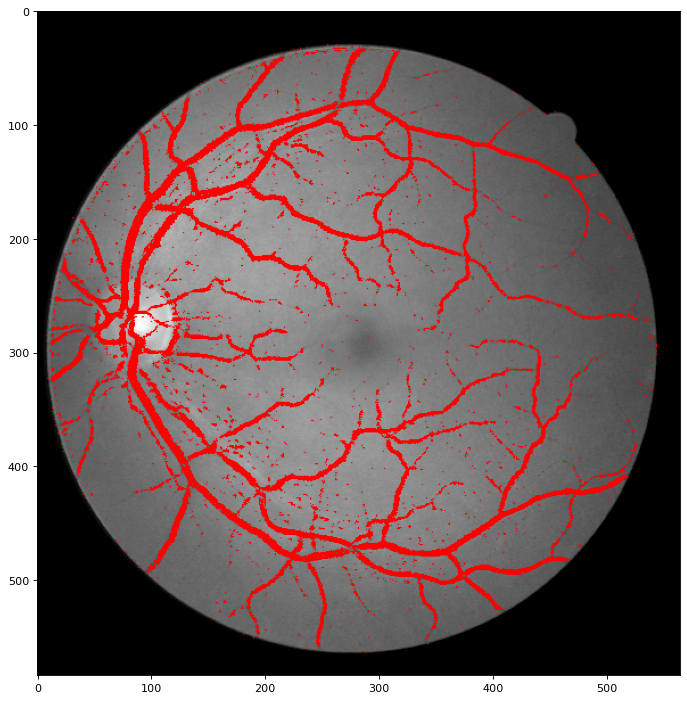

Accuracy score: 0.9308787582363633

F1 score: 0.7031565147236789

Confusion matrix:

     t/p      0     1 
        0 1156955 30590 
        1 63602 111560 
Sensivity: 0.6368961304392505
Specificity: 0.9742409761314308


(0.931, 0.703, 1156955, 30590, 63602, 111560)

In [31]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

## Ejecución con 6 núcleos y lightGBM

#### PARAMETERS

Population size: 80

k (tournament selection): 2

alpha (recombination): 0.6

sigma (mutation): 0.4

Mutation probability: 0.1
Recombination probability: 0.6

#### BEST RESULT

Fitness: 0.6404590596364136

Kernels: 
[-0.01896793  0.16685353 -0.04073357  0.03758321  0.45592933 -0.04249785
 -0.00813372  0.3915514   0.19219148  0.03675487 -0.07839416  0.05116644
 -0.21755329  0.05680535  0.20516737 -0.04514586  0.01780444  0.07979146
  0.01379418  0.06380112 -0.00979854 -0.06510548  0.14660235  0.0230366
  0.06971492  0.12629304  0.01615944  0.00659898  0.10571844  0.08066367
  0.14782103  0.02178885  0.12769831 -0.03491611  0.10530013  0.01098105
 -0.01274467 -0.00326741  0.14321016  0.04362726  0.03971864 -0.3119849
 -0.36954096  0.15610715  0.05976684  0.23836276  0.11750713 -0.0482398
  0.06599869  0.1778247   0.30698926 -0.01511237  0.07534552  0.06109792
  0.10522571 -0.2492347   0.06034471 -0.00848499 -0.18687127 -0.02362721
 -0.12048924  0.01385463  0.03609491  0.24271949 -0.0806105   0.06153911
 -0.0107063  -0.04703809  0.46960823  0.16288285 -0.05486061  0.2454989
  0.01421689  0.1126543  -0.04798373  0.17454166  0.10024941 -0.12656502
  0.00181107 -0.01693136  0.03298144  0.11627212  0.07960637 -0.10203323
  0.11074288  0.06768355  0.03535985  0.01544107  0.08108118 -0.05501648
  0.02114117 -0.05966445 -0.05202833 -0.20416821 -0.33658119  0.11517139
  0.18499377 -0.54335435  0.08543699 -0.04258854  0.06531281 -0.25807591
  0.18750533  0.03718695  0.0297607  -0.06573044  0.09287543 -0.00086815
 -0.0620434  -0.00877052  0.12896096  0.17194058  0.02684301 -0.06728001
  0.61282197  0.00965481 -0.03104777 -0.21216407 -0.04838598  0.08602382
  0.11233927  0.12737903 -0.07954881  0.00346604  0.10193438  0.0709723
 -0.30516896  0.02415857  0.0097318   0.17443726  0.49972783 -0.20897906
 -0.5545098   0.06199937 -0.50610131 -0.08374255 -0.05476889  0.1658088
  0.51391149 -0.02487457 -0.34191152 -0.37124034 -0.10180524  0.01478267
  0.11479996 -0.06664025  0.36000988  0.16913314 -0.08847245 -0.0164314
  0.09117855  0.06823051 -0.07336272  0.06465331 -0.06436073  0.1401178
  0.0681433   0.02841955 -0.11472597  0.41836398  0.37828967  0.1046755
 -0.29145534  0.00834706  0.08921102  0.02397168]

In [ ]:
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=True)